In [1]:
from __future__ import print_function, division
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from IPython.core.pylabtools import figsize
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

# Algorithm for Human Deceit

"Have you ever cheat on a test?"

True rate < observed rate 

## Binomial Distribution

Properties:
* $N$: + int, represents the nums of trials / the nums of instances of potential events.
* $p$: probability of an event occuring in a single trial.

Discrete distribution. 
$$ 0 \leq p \leq N$$

$$P(X=k) = {{N} \choose {k}} p^{k} (1 - p)^{N-k}$$

* $X$: binomial random variable with parameters $p$ and $N$:
$$
X \sim \text{Bin}(N, p)
\\
0 \leq X \leq N
$$

* The larger the $p$ is, the more events are likely to occur.

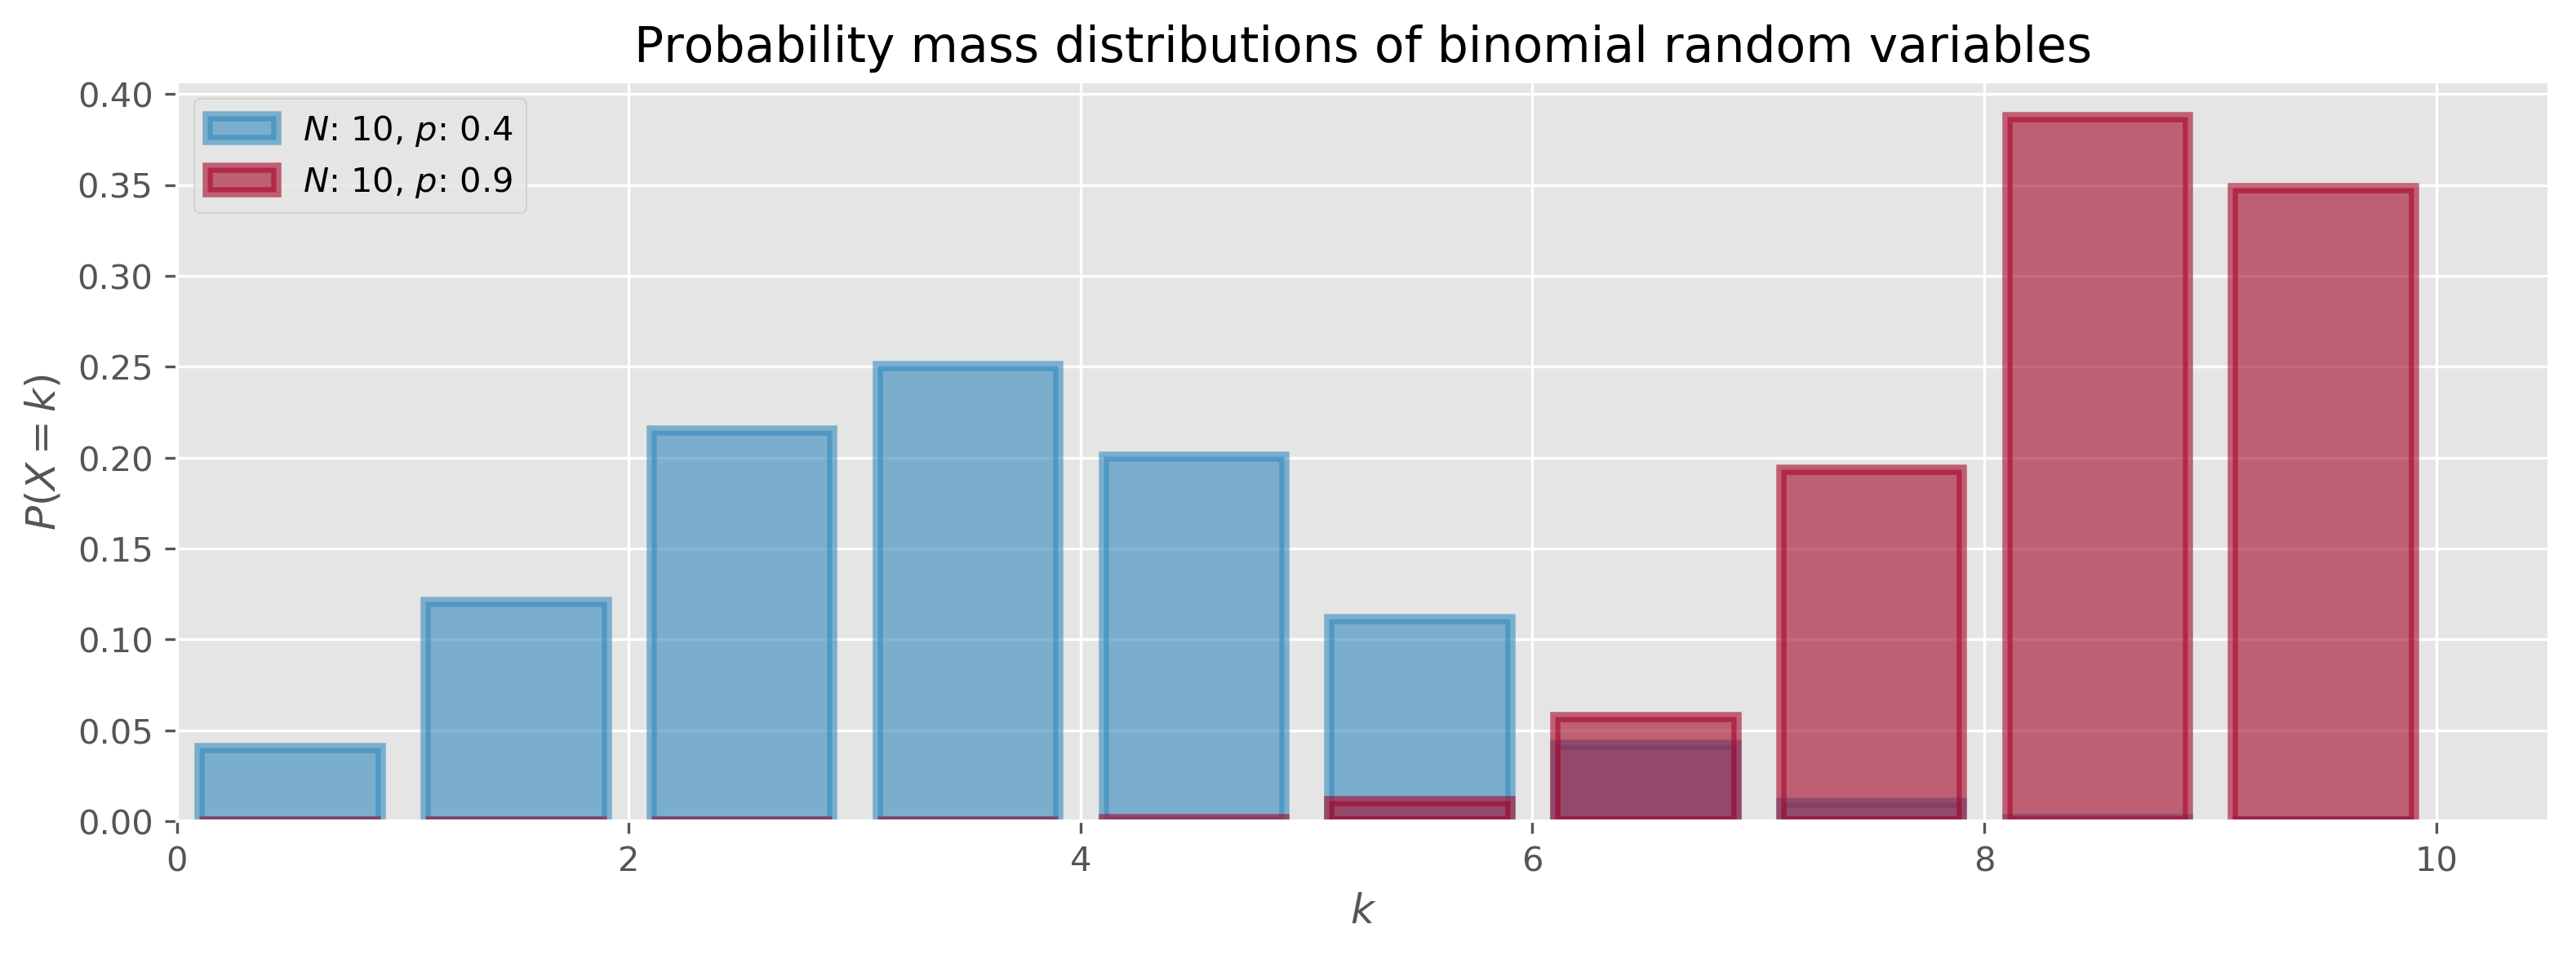

In [15]:
figsize(12.5, 4);

import scipy.stats as stats
binomial = stats.binom
parameters = [(10, 0.4), (10, 0.9)]
colors = ['#348ABD', '#A60628']

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i],
            edgecolor=colors[i], alpha=.6, label="$N$: %d, $p$: %.1f" %(N, p),linewidth=3);

plt.legend(loc='upper left');
plt.xlim(0, 10.5);
plt.xlabel('$k$');
plt.ylabel('$P(X = k)$');
plt.title('Probability mass distributions of binomial random variables');

## Example: Cheating Among Students

* $N$: Total number of students who took exam,
* $X$: 'Yes I did cheat.'

In [10]:
N = 100
p = pm.Uniform("freq_cheating", 0, 1)

In [11]:
true_answers = pm.Bernoulli("truths", p, size=N)

In [12]:
first_coin_flips = pm.Bernoulli("first_flips", 0.5, size=N)
print(first_coin_flips.value)

[False False  True False False  True  True  True  True False False False
  True  True  True  True False  True  True  True False  True  True False
 False  True  True False  True  True False False False False  True  True
  True  True False False  True  True False  True  True  True  True False
  True  True False  True  True False  True False  True  True False  True
  True False  True False  True False False  True False  True False False
  True False False False  True False  True False  True  True  True False
  True  True  True  True False False  True  True  True  True  True False
 False False False False]


In [13]:
second_coin_flips = pm.Bernoulli("second_flips", 0.5, size=N)

In [14]:
@pm.deterministic
def observed_proportion(t_a = true_answers,
                       fc = first_coin_flips,
                       sc = second_coin_flips):
    observed = fc*t_a + (1 - fc) * sc
    return observed.sum() / float(N)

In [15]:
observed_proportion.value

0.64

In [16]:
X = 35
observations = pm.Binomial("obs", N, observed_proportion, observed=True, value=X)

In [17]:
model = pm.Model([p, true_answers, first_coin_flips, second_coin_flips, observed_proportion, observations])

# to be explained in ch3
mcmc = pm.MCMC(model)
mcmc.sample(40000, 15000)

TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

# Alternative

$$P(\text{"YES"}) = P(\text{heads on 1st coin}) \times P(\text{cheater})\\
+ P(\text{tails on the 1st coin}) \times P(\text{heads on the 2nd coin})=\\
\frac{1}{2} \times p + \frac{1}{2} \times \frac{1}{2}$$

In [18]:
p = pm.Uniform("freq_cheating", 0, 1)

In [19]:
@pm.deterministic
def p_skewed(p=p):
    return 0.5 * p + 0.25

In [20]:
yes_responses = pm.Binomial("number_cheaters", 100, p_skewed, value=15, observed=True)

In [21]:
model = pm.Model([yes_responses, p_skewed, p])

# to be explained in Ch 3
mcmc = pm.MCMC(model)
mcmc.sample(25000, 2500)

 [-----------------100%-----------------] 25000 of 25000 complete in 1.3 sec

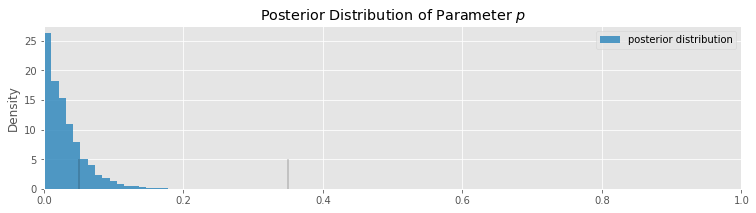

In [22]:
figsize(12.5, 3)

p_trace = mcmc.trace("freq_cheating")[:]
plt.hist(p_trace, histtype='stepfilled', normed=True,
        alpha=0.85, bins=30, label='posterior distribution',
        color='#348ABD');
plt.vlines([0.05, 0.35], [0, 0], [5, 5], alpha=.2);
plt.xlim(0,1);
plt.ylabel('Density');
plt.title('Posterior Distribution of Parameter $p$');
plt.legend();

## More PyMC tricks

In [24]:
beta = pm.Normal("coefficients", 0, size=(N, 1))

ValueError: No value given for parent tau